<a href="https://colab.research.google.com/github/kaliautkarsh98/Digit-recognizer-/blob/master/digit_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                                 title                                                size  lastUpdated          downloadCount  
------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
imoore/60k-stack-overflow-questions-with-quality-rate               60k Stack Overflow Questions with Quality Rating     21MB  2020-09-08 09:26:05            468  
ihelon/lego-minifigures-classification                              LEGO Minifigures Classification                      12MB  2020-09-08 16:48:53            516  
anikannal/solar-power-generation-data                               Solar Power Generation Data                           2MB  2020-08-18 15:52:03           2357  
douglaskgaraujo/opportunity-insights-real-time-economic-tracker-us  Opportunity Insights real time Economic Tracker US   22MB  2020-09-07 18:23:07

In [82]:
! kaggle competitions download -c digit-recognizer

 55% 5.00M/9.16M [00:00<00:00, 22.4MB/s]
100% 9.16M/9.16M [00:00<00:00, 36.2MB/s]
 82% 5.00M/6.09M [00:00<00:00, 20.9MB/s]
100% 6.09M/6.09M [00:00<00:00, 24.1MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 75.0MB/s]


In [83]:
! unzip test.csv.zip
! unzip train.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               


In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import seaborn as sns 
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


In [85]:
train=pd.read_csv('/content/train.csv') 
test=pd.read_csv('/content/test.csv')

In [86]:
y=train['label'].values
x=train.drop('label',axis=1).values
print(x.shape)
print(y.shape)

(42000, 784)
(42000,)


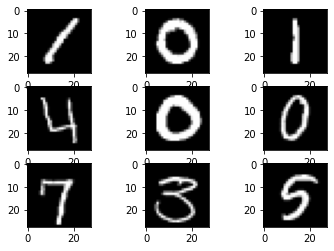

In [87]:
x=x.reshape(x.shape[0],28,28)
fig=plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(x[i],cmap='gray')

In [88]:
x=x.reshape(-1,28,28,1)
test=test.values.reshape(-1,28,28,1)

In [89]:
#normalization 
x=x/255.0
test=test/255.0

In [90]:
test.shape

(28000, 28, 28, 1)

In [92]:
from keras.utils.np_utils import to_categorical
y=to_categorical(y)
y

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [93]:
from sklearn.model_selection import train_test_split
train_x,valid_x,train_y,valid_y=train_test_split(x,y,random_state=1,test_size=0.2)

In [96]:
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,GlobalAveragePooling2D,MaxPool2D,Flatten

model=Sequential()
model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',input_shape=(28,28,1)))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu',input_shape=(28,28,1)))
model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10,activation='softmax'))

In [97]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [99]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1/.255,width_shift_range=0.2,height_shift_range=0.2,zoom_range=0.2,fill_mode='nearest')
train_generator=train_datagen.flow(train_x,train_y,batch_size=128)
valid_datagen=ImageDataGenerator(rescale=1/.255)
valid_generator=valid_datagen.flow(valid_x,valid_y,batch_size=128)

In [100]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(
    rescale=1/.255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)
train_generator=train_datagen.flow(
    train_x,train_y,
    batch_size=128
    )

valid_datagen=ImageDataGenerator(
    rescale=1/.255)
valid_generator=valid_datagen.flow(
    valid_x,valid_y,
    batch_size=128)

In [101]:
import tensorflow as tf
callback=tf.keras.callbacks.EarlyStopping(monitor='accuracy',min_delta=0,patience=5,verbose=2,mode='auto',restore_best_weights=True)
history=model.fit(train_generator,epochs=100,steps_per_epoch=train_x.shape[0]//128,verbose=2,validation_data=valid_generator,validation_steps=valid_x.shape[0]//128,callbacks=[callback])

Epoch 1/100
262/262 - 339s - loss: 1.0776 - accuracy: 0.6172 - val_loss: 0.2983 - val_accuracy: 0.9061
Epoch 2/100
262/262 - 336s - loss: 0.2628 - accuracy: 0.9195 - val_loss: 0.1026 - val_accuracy: 0.9685
Epoch 3/100
262/262 - 338s - loss: 0.1636 - accuracy: 0.9516 - val_loss: 0.0667 - val_accuracy: 0.9792
Epoch 4/100
262/262 - 337s - loss: 0.1272 - accuracy: 0.9616 - val_loss: 0.0715 - val_accuracy: 0.9798
Epoch 5/100
262/262 - 340s - loss: 0.1028 - accuracy: 0.9693 - val_loss: 0.0537 - val_accuracy: 0.9847
Epoch 6/100
262/262 - 338s - loss: 0.0943 - accuracy: 0.9711 - val_loss: 0.0715 - val_accuracy: 0.9782
Epoch 7/100
262/262 - 336s - loss: 0.0805 - accuracy: 0.9749 - val_loss: 0.0423 - val_accuracy: 0.9876
Epoch 8/100
262/262 - 338s - loss: 0.0739 - accuracy: 0.9767 - val_loss: 0.0435 - val_accuracy: 0.9876
Epoch 9/100
262/262 - 337s - loss: 0.0616 - accuracy: 0.9814 - val_loss: 0.0383 - val_accuracy: 0.9886
Epoch 10/100
262/262 - 338s - loss: 0.0611 - accuracy: 0.9813 - val_loss:

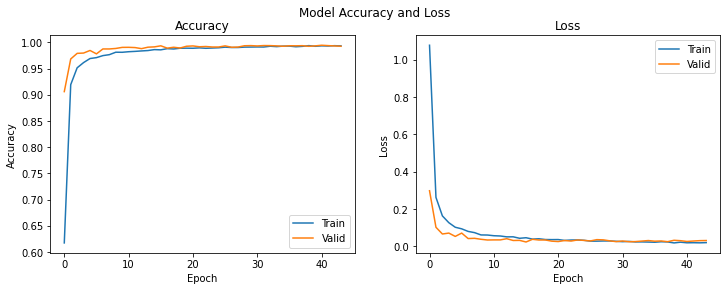

In [103]:
  import matplotlib.pyplot as plt
def plot_model(history):
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,4))
    fig.suptitle('Model Accuracy and Loss')

    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.title.set_text('Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train','Valid'],loc=4)

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.title.set_text('Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train','Valid'],loc=1)

    fig.show()

plot_model(history)


In [104]:
prediction=model.predict(test)
prediction=np.argmax(prediction,axis=1)
prediction=pd.Series(prediction,name="Label")

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),prediction],axis = 1)
submission.to_csv("digit_recognizer.csv",index=False)